In [2]:
import pandas
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [3]:
bin_dims = (5, 3)

y_bins = np.linspace(0, 68, bin_dims[1] + 1)  
y_df = pd.DataFrame({"y_bin_start": y_bins[:-1], "y_bin_end": y_bins[1:]})

x_bins = np.linspace(0, 105, bin_dims[0] + 1)
x_df = pd.DataFrame({"x_bin_start": x_bins[:-1], "x_bin_end": x_bins[1:]})

segments_df = pd.DataFrame(
    list(product(
        zip(x_df["x_bin_start"], x_df["x_bin_end"]),
        zip(y_df["y_bin_start"], y_df["y_bin_end"])
    )),
    columns=["x_bins", "y_bins"]
)
segments_df["x_bin_start"], segments_df["x_bin_end"] = zip(*segments_df["x_bins"])
segments_df["y_bin_start"], segments_df["y_bin_end"] = zip(*segments_df["y_bins"])
segments_df = segments_df.drop(columns=["x_bins", "y_bins"])
segments_df['segment'] = segments_df.index + 1


In [4]:
df = pd.read_csv('../00_data/01_actions_data/actions_segmented_5x3.csv')

ball_movements = ['pass', 'cross', 'throw_in', 'goalkick', 'freeckick_crossed', 'freekick_short', 'goal_kick']
attack_moves = ['shot', 'shot_freekick', 'shot_penalty']
defensive_moves = ['interception', 'tackle', 'clearance', 'keeper_save', 'keeper_claim', 'keeper_punch', 'keeper_pick_up', 'keeper_sweeper', 'keeper_success']
graph_df = pd.DataFrame()

game_ids = df['game_id'].unique()

for game in tqdm(game_ids, desc="Games Progress"):
     teams = df[df['game_id'] == game]['team_id'].unique()
     for team in teams:
          team_df = df[(df['game_id'] == game) & (df['team_id'] == team)]
          acts = team_df[team_df['type_name'].isin(ball_movements) & (team_df['result_name'] == 'success')]
          
          G = nx.DiGraph()

          for _, row in acts.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if G.has_edge(player, recipient):
                    G[player][recipient]['weight'] += 1
               else:
                    G.add_edge(player, recipient, weight=1)
          
          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not G.has_edge(u, v):
                    G.add_edge(u, v, weight=0)

          attack_actions = team_df[(team_df['type_name'].isin(attack_moves))]
          attack_G = nx.DiGraph()
          
          for _, row in attack_actions.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if attack_G.has_edge(player, recipient):
                    attack_G[player][recipient]['weight'] += 1
               else:
                    attack_G.add_edge(player, recipient, weight=1)

          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not attack_G.has_edge(u, v):
                    attack_G.add_edge(u, v, weight=0)

          graph_df = pd.concat([graph_df, pd.DataFrame({'game_id':[game] , 'team': [team], 'ball_movements_graph': [G], 'attack_graph': [attack_G]})])

graph_df

Games Progress: 100%|██████████| 1826/1826 [00:39<00:00, 46.36it/s]


,game_id,team,ball_movements_graph,attack_graph
0,2500089,1659,"(11.0, 13.0, 10.0, 9.0, 6.0, 8.0, 1, 2, 3, 4, ...","(11.0, 13.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
0,2500089,1646,"(12.0, 9.0, 11.0, 14.0, 4.0, 7.0, 10.0, 15.0, ...","(5.0, 2.0, 3.0, 14.0, 11.0, 1, 4, 6, 7, 8, 9, ..."
0,2500090,1628,"(8.0, 7.0, 10.0, 11.0, 9.0, 6.0, 14.0, 12.0, 1...","(5.0, 2.0, 4.0, 14.0, 1, 3, 6, 7, 8, 9, 10, 11..."
0,2500090,1627,"(9.0, 11.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13..."
0,2500091,1673,"(11.0, 9.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(11.0, 9.0, 10.0, 1, 2, 3, 4, 5, 6, 7, 8, 12, ..."
...,...,...,...,...
0,2565549,692,"(6.0, 9.0, 13.0, 11.0, 8.0, 10.0, 1, 2, 3, 4, ...","(9.0, 11.0, 13.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
0,2565556,674,"(8.0, 12.0, 9.0, 11.0, 10.0, 4.0, 5.0, 13.0, 6...","(2.0, 6.0, 3.0, 1.0, 12.0, 14.0, 15.0, 11.0, 1..."
0,2565556,714,"(8.0, 13.0, 11.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(11.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13..."
0,2565557,696,"(8.0, 11.0, 4.0, 10.0, 12.0, 7.0, 15.0, 9.0, 1...","(3.0, 2.0, 11.0, 14.0, 15.0, 1, 4, 5, 6, 7, 8,..."


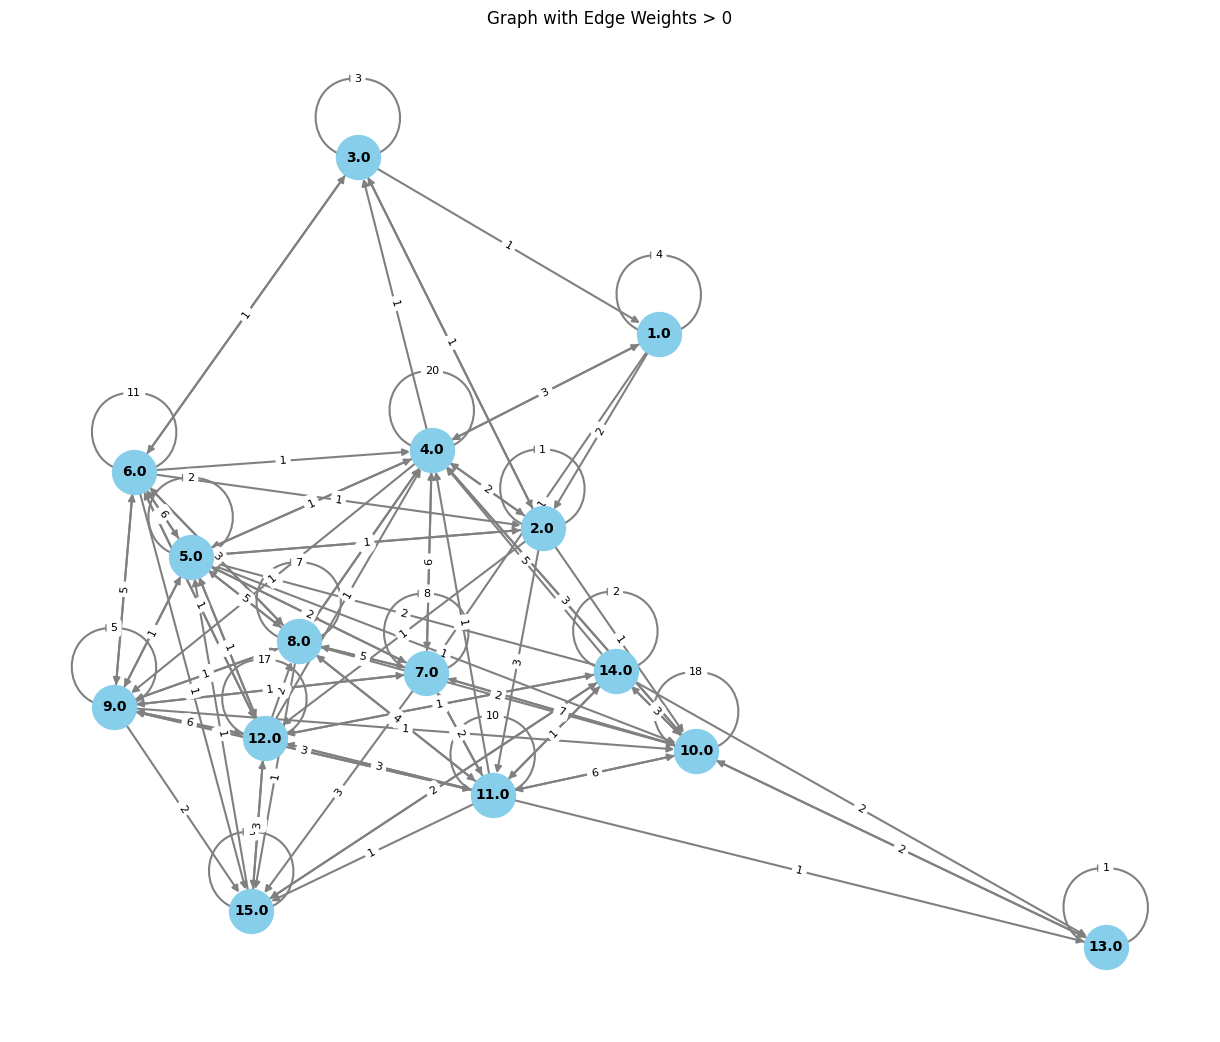

In [5]:
G = graph_df.iloc[1]['ball_movements_graph']

edges_to_draw = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]

G_filtered = G.edge_subgraph(edges_to_draw)

pos = nx.spring_layout(G_filtered)

plt.figure(figsize=(12, 10))
nx.draw(G_filtered, pos, with_labels=True, font_weight='bold', node_size=1000,
        node_color='skyblue', font_size=10, edge_color='gray',
        width=1.5, arrows=True, arrowstyle='-|>')

edge_labels = nx.get_edge_attributes(G_filtered, 'weight')
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=8)

plt.title("Graph with Edge Weights > 0")
plt.show()

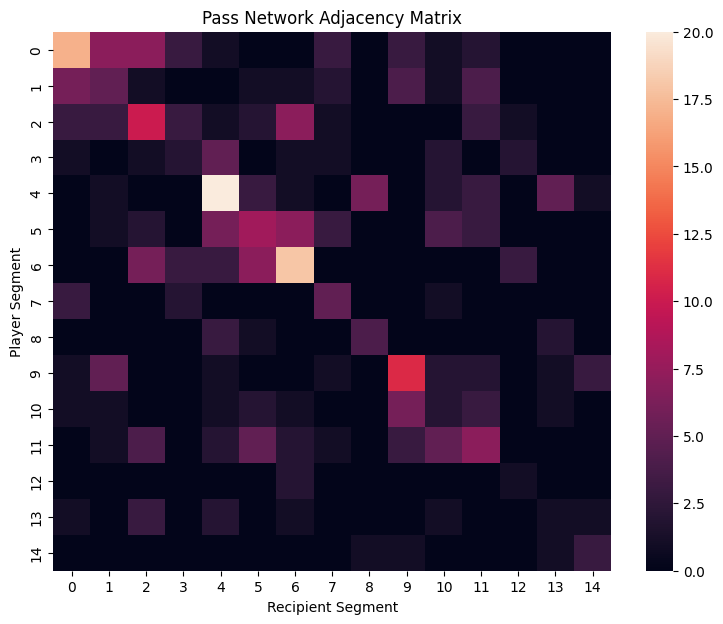

In [7]:
adj = nx.adjacency_matrix(G).todense()

plt.figure(figsize=(9, 7))
sns.heatmap(adj, fmt='d')
plt.xlabel('Recipient Segment')
plt.ylabel('Player Segment')
plt.title('Pass Network Adjacency Matrix')
plt.show()

In [8]:
matches = pd.read_csv('../00_data/01_actions_data/matches.csv')
matches = pd.merge(matches, graph_df, left_on=['game_id', 'home_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'home_team_pass_graph', 'attack_graph': 'home_team_attack_graph'}, inplace=True)

matches = pd.merge(matches, graph_df, left_on=['game_id', 'away_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'away_team_pass_graph', 'attack_graph': 'away_team_attack_graph'}, inplace=True)

matches = matches[['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'result', 'home_team_pass_graph', 'away_team_pass_graph', 'home_team_attack_graph', 'away_team_attack_graph']]
matches

,date,home_team,away_team,home_goals,away_goals,result,home_team_pass_graph,away_team_pass_graph,home_team_attack_graph,away_team_attack_graph
0,2017-08-04,Monaco,Toulouse,3,2,H,"(4.0, 10.0, 7.0, 14.0, 6.0, 3.0, 5.0, 2.0, 1.0...","(11.0, 9.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(2.0, 1.0, 14.0, 11.0, 3, 4, 5, 6, 7, 8, 9, 10...","(13.0, 11.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
1,2017-08-05,Saint-Étienne,Nice,1,0,H,"(8.0, 11.0, 12.0, 14.0, 13.0, 10.0, 7.0, 4.0, ...","(6.0, 9.0, 11.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(1.0, 2.0, 5.0, 11.0, 14.0, 3, 4, 6, 7, 8, 9, ...","(11.0, 9.0, 13.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
2,2017-08-05,Olympique Lyonnais,Strasbourg,4,0,H,"(10.0, 7.0, 4.0, 3.0, 9.0, 6.0, 8.0, 11.0, 14....","(11.0, 6.0, 9.0, 10.0, 13.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 3.0, 1.0, 14.0, 12.0, 4, 6, 7, 8, 9...","(11.0, 13.0, 10.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8..."
3,2017-08-05,Metz,Guingamp,1,3,A,"(8.0, 11.0, 4.0, 7.0, 10.0, 12.0, 9.0, 6.0, 1....","(6.0, 9.0, 8.0, 11.0, 13.0, 10.0, 1, 2, 3, 4, ...","(2.0, 5.0, 12.0, 14.0, 1, 3, 4, 6, 7, 8, 9, 10...","(11.0, 8.0, 9.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 10..."
4,2017-08-05,PSG,Amiens SC,2,0,H,"(15.0, 9.0, 12.0, 11.0, 7.0, 10.0, 14.0, 8.0, ...","(11.0, 9.0, 6.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(3.0, 2.0, 5.0, 1.0, 14.0, 13.0, 4, 6, 7, 8, 9...","(11.0, 10.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 9, 12, ..."
...,...,...,...,...,...,...,...,...,...,...
1821,2018-05-20,Udinese,Bologna,1,0,H,"(10.0, 11.0, 6.0, 7.0, 8.0, 15.0, 12.0, 9.0, 4...","(11.0, 8.0, 13.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(6.0, 2.0, 14.0, 13.0, 11.0, 12.0, 15.0, 1, 3,...","(11.0, 9.0, 10.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 8..."
1822,2018-05-20,Napoli,Crotone,2,1,H,"(11.0, 9.0, 6.0, 7.0, 8.0, 13.0, 10.0, 14.0, 1...","(11.0, 6.0, 9.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(3.0, 2.0, 1.0, 4.0, 14.0, 11.0, 5, 6, 7, 8, 9...","(11.0, 9.0, 13.0, 8.0, 10.0, 1, 2, 3, 4, 5, 6,..."
1823,2018-05-20,Milan,Fiorentina,5,1,H,"(12.0, 10.0, 14.0, 13.0, 11.0, 9.0, 6.0, 5.0, ...","(11.0, 8.0, 13.0, 9.0, 10.0, 6.0, 1, 2, 3, 4, ...","(2.0, 5.0, 1.0, 3.0, 14.0, 15.0, 12.0, 13.0, 1...","(11.0, 9.0, 8.0, 10.0, 13.0, 1, 2, 3, 4, 5, 6,..."
1824,2018-05-20,Barcelona,Real Sociedad,1,0,H,"(10.0, 14.0, 7.0, 13.0, 8.0, 6.0, 5.0, 12.0, 4...","(11.0, 13.0, 9.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(1.0, 2.0, 4.0, 11.0, 14.0, 13.0, 3, 5, 6, 7, ...","(11.0, 9.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, ..."


# MLP

In [9]:
matches.sort_values(by='date', ascending=True, inplace=True)

matches['home_team_prev_mv_graph_1'] = matches.groupby('home_team')['home_team_pass_graph'].shift(1)
matches['away_team_prev_mv_graph_1'] = matches.groupby('away_team')['away_team_pass_graph'].shift(1)

matches['home_team_prev_attack_graph_1'] = matches.groupby('home_team')['home_team_attack_graph'].shift(1)
matches['away_team_prev_attack_graph_1'] = matches.groupby('away_team')['away_team_attack_graph'].shift(1)

matches['home_team_prev_mv_graph_2'] = matches.groupby('home_team')['home_team_pass_graph'].shift(2)
matches['away_team_prev_mv_graph_2'] = matches.groupby('away_team')['away_team_pass_graph'].shift(2)

matches['home_team_prev_attack_graph_2'] = matches.groupby('home_team')['home_team_attack_graph'].shift(2)
matches['away_team_prev_attack_graph_2'] = matches.groupby('away_team')['away_team_attack_graph'].shift(2)

matches['home_team_prev_mv_graph_3'] = matches.groupby('home_team')['home_team_pass_graph'].shift(3)
matches['away_team_prev_mv_graph_3'] = matches.groupby('away_team')['away_team_pass_graph'].shift(3)

matches['home_team_prev_attack_graph_3'] = matches.groupby('home_team')['home_team_attack_graph'].shift(3)
matches['away_team_prev_attack_graph_3'] = matches.groupby('away_team')['away_team_attack_graph'].shift(3)

matches = matches.dropna()
matches

,date,home_team,away_team,home_goals,away_goals,result,home_team_pass_graph,away_team_pass_graph,home_team_attack_graph,away_team_attack_graph,...,home_team_prev_attack_graph_1,away_team_prev_attack_graph_1,home_team_prev_mv_graph_2,away_team_prev_mv_graph_2,home_team_prev_attack_graph_2,away_team_prev_attack_graph_2,home_team_prev_mv_graph_3,away_team_prev_mv_graph_3,home_team_prev_attack_graph_3,away_team_prev_attack_graph_3
255,2017-09-22,Lille,Monaco,0,4,A,"(8.0, 12.0, 7.0, 5.0, 9.0, 14.0, 13.0, 4.0, 1....","(13.0, 10.0, 11.0, 6.0, 9.0, 8.0, 1, 2, 3, 4, ...","(6.0, 2.0, 5.0, 15.0, 14.0, 10.0, 12.0, 1, 3, ...","(10.0, 11.0, 9.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 8...",...,"(4.0, 2.0, 5.0, 12.0, 14.0, 11.0, 15.0, 1, 3, ...","(10.0, 11.0, 13.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8...","(8.0, 5.0, 4.0, 1.0, 13.0, 10.0, 2.0, 7.0, 12....","(11.0, 9.0, 8.0, 6.0, 13.0, 10.0, 1, 2, 3, 4, ...","(2.0, 1.0, 6.0, 11.0, 14.0, 12.0, 15.0, 13.0, ...","(11.0, 8.0, 13.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 10...","(8.0, 12.0, 9.0, 6.0, 5.0, 10.0, 4.0, 13.0, 7....","(11.0, 6.0, 9.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(5.0, 2.0, 14.0, 10.0, 11.0, 1, 3, 4, 6, 7, 8,...","(11.0, 9.0, 8.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 10..."
254,2017-09-22,Nice,Angers SCO,2,2,D,"(4.0, 1.0, 9.0, 12.0, 8.0, 5.0, 7.0, 6.0, 11.0...","(11.0, 13.0, 9.0, 6.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 1.0, 10.0, 11.0, 14.0, 3, 4, 6, 7, ...","(13.0, 11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, ...",...,"(4.0, 2.0, 1.0, 14.0, 3, 5, 6, 7, 8, 9, 10, 11...","(10.0, 11.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 12...","(14.0, 15.0, 12.0, 9.0, 10.0, 11.0, 8.0, 7.0, ...","(11.0, 9.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(3.0, 2.0, 5.0, 14.0, 11.0, 12.0, 1, 4, 6, 7, ...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13...","(14.0, 11.0, 10.0, 7.0, 12.0, 8.0, 4.0, 5.0, 6...","(6.0, 9.0, 11.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 1.0, 11.0, 14.0, 15.0, 12.0, 3, 4, ...","(10.0, 11.0, 13.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6,..."
259,2017-09-23,Juventus,Torino,4,0,H,"(8.0, 11.0, 12.0, 14.0, 15.0, 6.0, 9.0, 10.0, ...","(11.0, 8.0, 13.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(1.0, 2.0, 5.0, 4.0, 10.0, 14.0, 11.0, 3, 6, 7...","(11.0, 13.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10...",...,"(5.0, 2.0, 6.0, 11.0, 12.0, 14.0, 1, 3, 4, 7, ...","(11.0, 13.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 10...","(11.0, 8.0, 7.0, 12.0, 14.0, 5.0, 15.0, 10.0, ...","(9.0, 6.0, 13.0, 10.0, 8.0, 11.0, 1, 2, 3, 4, ...","(5.0, 4.0, 2.0, 13.0, 14.0, 11.0, 1, 3, 6, 7, ...","(11.0, 13.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 10...","(12.0, 9.0, 14.0, 7.0, 4.0, 5.0, 10.0, 1.0, 2....","(6.0, 9.0, 11.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 14.0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...","(11.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10, 12, ..."
266,2017-09-23,Olympique Lyonnais,Dijon,3,3,D,"(8.0, 11.0, 13.0, 10.0, 14.0, 15.0, 9.0, 4.0, ...","(11.0, 6.0, 9.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(3.0, 2.0, 1.0, 5.0, 14.0, 11.0, 4, 6, 7, 8, 9...","(11.0, 10.0, 8.0, 9.0, 13.0, 1, 2, 3, 4, 5, 6,...",...,"(5.0, 2.0, 4.0, 6.0, 12.0, 14.0, 11.0, 10.0, 1...","(9.0, 11.0, 10.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 12...","(12.0, 14.0, 10.0, 9.0, 13.0, 7.0, 11.0, 8.0, ...","(11.0, 13.0, 9.0, 8.0, 10.0, 6.0, 1, 2, 3, 4, ...","(3.0, 2.0, 7.0, 13.0, 14.0, 11.0, 1, 4, 5, 6, ...","(8.0, 11.0, 10.0, 13.0, 9.0, 1, 2, 3, 4, 5, 6,...","(10.0, 7.0, 4.0, 3.0, 9.0, 6.0, 8.0, 11.0, 14....","(13.0, 11.0, 9.0, 10.0, 8.0, 6.0, 1, 2, 3, 4, ...","(2.0, 5.0, 3.0, 1.0, 14.0, 12.0, 4, 6, 7, 8, 9...","(8.0, 11.0, 10.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 12..."
267,2017-09-23,Caen,Amiens SC,1,0,H,"(15.0, 6.0, 10.0, 12.0, 9.0, 4.0, 14.0, 8.0, 7...","(9.0, 6.0, 13.0, 11.0, 10.0, 8.0, 1, 2, 3, 4, ...","(6.0, 2.0, 1.0, 5.0, 4.0, 14.0, 12.0, 10.0, 3,...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13...",...,"(2.0, 8.0, 5.0, 10.0, 11.0, 14.0, 13.0, 1, 3, ...","(8.0, 11.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 9, 10, ...","(8.0, 11.0, 4.0, 9.0, 6.0, 7.0, 3.0, 10.0, 5.0...","(11.0, 13.0, 9.0, 6.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 14.0, 11.0, 1, 3, 4

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset

df = matches.copy()

graph_columns = [
    'home_team_prev_mv_graph_1', 'away_team_prev_mv_graph_1',
    'home_team_prev_attack_graph_1', 'away_team_prev_attack_graph_1',
    'home_team_prev_mv_graph_2', 'away_team_prev_mv_graph_2',
    'home_team_prev_attack_graph_2', 'away_team_prev_attack_graph_2',
    'home_team_prev_mv_graph_3', 'away_team_prev_mv_graph_3',
    'home_team_prev_attack_graph_3', 'away_team_prev_attack_graph_3'
]

for col in graph_columns:
    df[col] = df[col].apply(lambda x: x if isinstance(x, np.ndarray) else np.array(x))

le = LabelEncoder()
df['result'] = le.fit_transform(df['result'])

X = np.array([np.concatenate([row[col] for col in graph_columns]) for _, row in df.iterrows()])
y = df['result'].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, 
    test_size=0.2, 
    stratify=y_tensor.numpy(),
    random_state=42
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return self.net(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X.shape[1]
output_size = len(le.classes_)

model = MLP(input_size, output_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

best_val_loss = float('inf')
patience = 10
no_improve = 0

for epoch in range(200):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss/len(test_loader)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        no_improve = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        no_improve += 1

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*correct/total:.2f}%")

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Final Test Accuracy: {100*correct/total:.2f}%")

Epoch 1: Train Loss: 1.1207 | Val Loss: 1.0690 | Val Acc: 45.54%
Epoch 2: Train Loss: 1.0775 | Val Loss: 1.0823 | Val Acc: 45.54%
Epoch 3: Train Loss: 1.0675 | Val Loss: 1.0769 | Val Acc: 45.21%
Epoch 4: Train Loss: 1.0685 | Val Loss: 1.0751 | Val Acc: 45.54%
Epoch 5: Train Loss: 1.0585 | Val Loss: 1.0730 | Val Acc: 45.21%
Epoch 6: Train Loss: 1.0529 | Val Loss: 1.0761 | Val Acc: 45.21%
Epoch 7: Train Loss: 1.0641 | Val Loss: 1.0787 | Val Acc: 45.54%
Epoch 8: Train Loss: 1.0528 | Val Loss: 1.0758 | Val Acc: 45.54%
Epoch 9: Train Loss: 1.0486 | Val Loss: 1.0795 | Val Acc: 45.21%
Epoch 10: Train Loss: 1.0398 | Val Loss: 1.0852 | Val Acc: 43.56%
Early stopping at epoch 11
Final Test Accuracy: 45.54%


In [11]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
     for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        89
           D       0.00      0.00      0.00        76
           H       0.46      1.00      0.63       138

    accuracy                           0.46       303
   macro avg       0.15      0.33      0.21       303
weighted avg       0.21      0.46      0.29       303



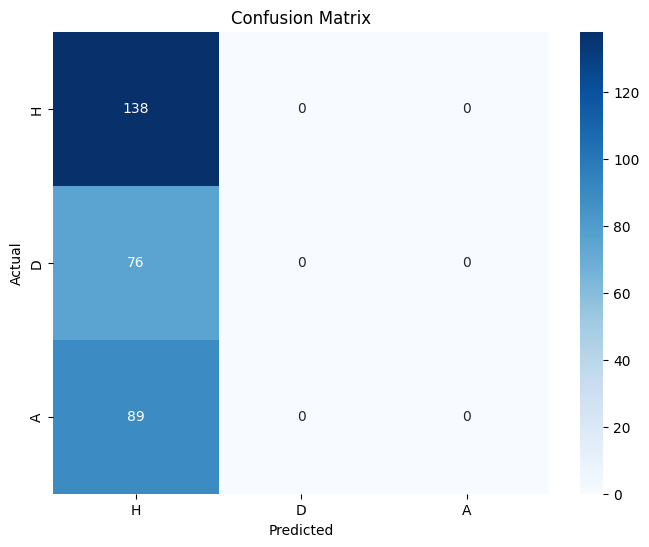

In [12]:
# confusion matrix with seaborn

cm = confusion_matrix(y_true, y_pred)[::-1, ::-1]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['H', 'D', 'A'], yticklabels=['H', 'D', 'A'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import networkx as nx

df = matches.copy()

def graph_to_vector(graph):
    return nx.to_numpy_array(graph).flatten()

graph_columns = [
    'home_team_prev_mv_graph_1', 'away_team_prev_mv_graph_1',
    'home_team_prev_attack_graph_1', 'away_team_prev_attack_graph_1',
    'home_team_prev_mv_graph_2', 'away_team_prev_mv_graph_2',
    'home_team_prev_attack_graph_2', 'away_team_prev_attack_graph_2',
    'home_team_prev_mv_graph_3', 'away_team_prev_mv_graph_3',
    'home_team_prev_attack_graph_3', 'away_team_prev_attack_graph_3'
]

for col in graph_columns:
    df[col] = df[col].apply(graph_to_vector)

le = LabelEncoder()
df['result'] = le.fit_transform(df['result'])

def create_sequences(row):
    return np.stack([
        np.concatenate([
            row['home_team_prev_mv_graph_1'],
            row['away_team_prev_mv_graph_1'],
            row['home_team_prev_attack_graph_1'],
            row['away_team_prev_attack_graph_1']
        ]),
        np.concatenate([
            row['home_team_prev_mv_graph_2'],
            row['away_team_prev_mv_graph_2'],
            row['home_team_prev_attack_graph_2'],
            row['away_team_prev_attack_graph_2']
        ]),
        np.concatenate([
            row['home_team_prev_mv_graph_3'],
            row['away_team_prev_mv_graph_3'],
            row['home_team_prev_attack_graph_3'],
            row['away_team_prev_attack_graph_3']
        ])
    ])

X = np.array([create_sequences(row) for _, row in df.iterrows()])
y = df['result'].values

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, 
    test_size=0.2, 
    stratify=y_tensor.numpy(),
    random_state=42
)

batch_size = 64
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size)

class MatchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MatchRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.dropout(out[:, -1, :])
        return self.fc(out)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MatchRNN(
    input_size=900,
    hidden_size=256,
    num_layers=2,
    output_size=len(le.classes_)
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

best_val_loss = float('inf')
best_val_acc = 0.0

for epoch in range(100):
    model.train()
    train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            val_loss += loss_fn(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    val_acc = correct / total

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"New best model saved at epoch {epoch+1}")

    print(f"Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {100*val_acc:.2f}%")

model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    correct, total = 0, 0
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"\nBest Model Performance:")
print(f"Validation Loss: {best_val_loss:.4f}")
print(f"Validation Accuracy: {100*best_val_acc:.2f}%")
print(f"Final Test Accuracy: {100*correct/total:.2f}%")

New best model saved at epoch 1
Epoch 1: Train Loss: 1.3787 | Val Loss: 1.0751 | Val Acc: 45.54%
Epoch 2: Train Loss: 1.0721 | Val Loss: 1.0751 | Val Acc: 45.54%
New best model saved at epoch 3
Epoch 3: Train Loss: 1.0769 | Val Loss: 1.0664 | Val Acc: 45.54%
Epoch 4: Train Loss: 1.0718 | Val Loss: 1.0831 | Val Acc: 45.54%
Epoch 5: Train Loss: 1.0791 | Val Loss: 1.0718 | Val Acc: 45.54%
Epoch 6: Train Loss: 1.0809 | Val Loss: 1.0706 | Val Acc: 45.54%
Epoch 7: Train Loss: 1.0748 | Val Loss: 1.0728 | Val Acc: 45.54%
Epoch 8: Train Loss: 1.0802 | Val Loss: 1.0915 | Val Acc: 45.54%
Epoch 9: Train Loss: 1.0787 | Val Loss: 1.0720 | Val Acc: 45.54%
Epoch 10: Train Loss: 1.0716 | Val Loss: 1.0742 | Val Acc: 45.54%
Epoch 11: Train Loss: 1.0748 | Val Loss: 1.0788 | Val Acc: 45.54%
Epoch 12: Train Loss: 1.0790 | Val Loss: 1.0744 | Val Acc: 45.54%
Epoch 13: Train Loss: 1.0702 | Val Loss: 1.0757 | Val Acc: 45.54%
Epoch 14: Train Loss: 1.0722 | Val Loss: 1.0768 | Val Acc: 45.54%
Epoch 15: Train Loss:

In [14]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
     for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          y_true.extend(labels.cpu().numpy())
          y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        89
           D       0.00      0.00      0.00        76
           H       0.46      1.00      0.63       138

    accuracy                           0.46       303
   macro avg       0.15      0.33      0.21       303
weighted avg       0.21      0.46      0.29       303



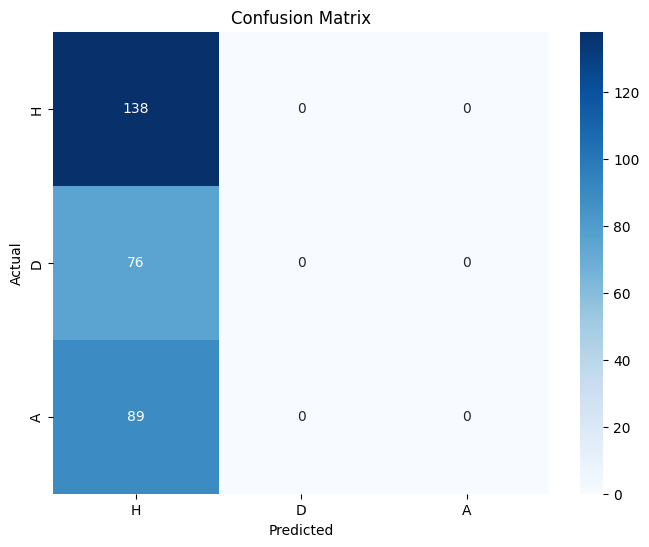

In [15]:
cm = confusion_matrix(y_true, y_pred)[::-1, ::-1]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['H', 'D', 'A'], yticklabels=['H', 'D', 'A'], cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()